<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/CNN_cifar10-flood_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Network (CNN)

Image Classification (CIAR-10) by CNN

Flood Loss

\begin{align*}
  \tilde{J}(\theta) = | J(\theta) - b| + b
\end{align*}
where $J(\theta)$ is the original loss.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FloodLoss(nn.Module):
    def __init__(self, b, device='cuda'):
        super(FloodLoss, self).__init__()
        self.b = b
        self.criterion = nn.CrossEntropyLoss().to(device)
    def forward(self, outputs, targets):
        loss = self.criterion(outputs, targets)
        return (loss - self.b).abs() + self.b

In [ ]:
# load CIFAR-10 data
train_dataset = dsets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ]))

test_dataset = dsets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ]))

#print(len(train_Dataset))

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_dataset,   # 分割するデータセット
      [40000, 10000])  # 分割数

print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))
print('test_dataset = ', len(test_dataset))



100%|████████████████████████████████████████████████████████████████| 170498071/170498071 [02:44<00:00, 1036072.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train_dataset =  40000
valid_dataset =  10000
test_dataset =  10000


In [ ]:
# Set up DataLoader
batch=128

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch,
        shuffle=True
    )

valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch,
        shuffle=True
    )

test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch,
        shuffle=True
    )


In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout2d(0.2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(32*8*8, 128)
        self.dropout3 = nn.Dropout2d(0.2)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

net = Network()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

if torch.cuda.is_available():
  net.cuda()

print('Network architecture for CNN\n', net)

cuda
Network architecture for CNN
 Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout3): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
#optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.001)


In [ ]:
# Define Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
###  training
print ('training start ...')
num_epochs = 50

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
#        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, labels)  # loss
        loss.backward()  # backward computation
        optimizer.step()  # optimization

    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:
#          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)

    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.4f}, train acc: {acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


training start ...


/home/kurita/anaconda3/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/50] train Loss: 0.0125, train acc: 0.4357 | val_loss: 0.0127, val_acc: 0.4314
Epoch [2/50] train Loss: 0.0107, train acc: 0.5120 | val_loss: 0.0110, val_acc: 0.4983
Epoch [3/50] train Loss: 0.0098, train acc: 0.5635 | val_loss: 0.0101, val_acc: 0.5456
Epoch [4/50] train Loss: 0.0091, train acc: 0.5912 | val_loss: 0.0096, val_acc: 0.5735
Epoch [5/50] train Loss: 0.0083, train acc: 0.6299 | val_loss: 0.0089, val_acc: 0.6017
Epoch [6/50] train Loss: 0.0077, train acc: 0.6672 | val_loss: 0.0084, val_acc: 0.6259
Epoch [7/50] train Loss: 0.0072, train acc: 0.6887 | val_loss: 0.0081, val_acc: 0.6486
Epoch [8/50] train Loss: 0.0069, train acc: 0.7017 | val_loss: 0.0079, val_acc: 0.6551
Epoch [9/50] train Loss: 0.0065, train acc: 0.7193 | val_loss: 0.0076, val_acc: 0.6639
Epoch [10/50] train Loss: 0.0063, train acc: 0.7355 | val_loss: 0.0076, val_acc: 0.6699
Epoch [11/50] train Loss: 0.0060, train acc: 0.7440 | val_loss: 0.0074, val_acc: 0.6740
Epoch [12/50] train Loss: 0.0057, train a

In [ ]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:
#        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total))

# save weights (You can save the model by uncomment the following line)
#torch.save(net.state_dict(), 'mnist_net.ckpt')


test_accuracy: 69.81 %


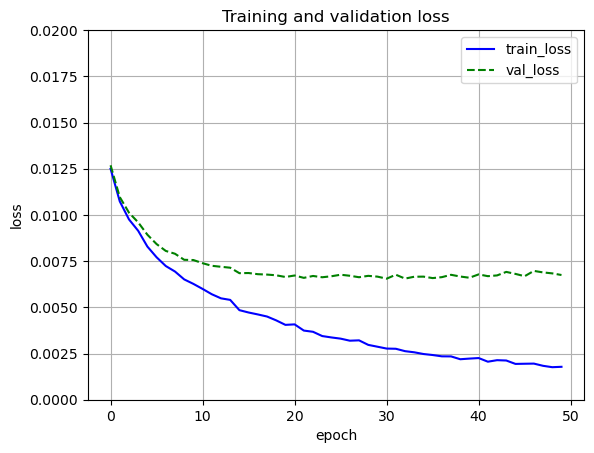

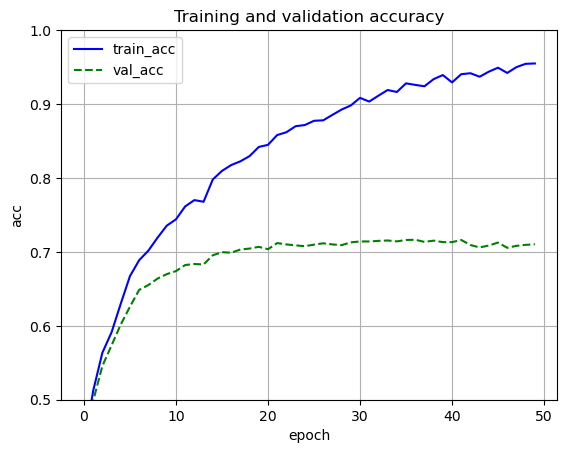

In [ ]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.ylim([0.0,0.02])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('images/CNN_cifar10_loss.png')
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.5, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.savefig('images/CNN_cifar10_acc.png')
plt.show()